<a href="https://colab.research.google.com/github/yanaySG/YOLOV3/blob/main/yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.cuda.is_available())

True


Building a YOLOv3 Object Detector with Darknet in the Cloud 
(GPU ENABLED)

In [2]:
#!rm -rf darknet
%rm -rf darknet

In [3]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15521, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 15521 (delta 0), reused 4 (delta 0), pack-reused 15514
Receiving objects: 100% (15521/15521), 14.17 MiB | 7.16 MiB/s, done.
Resolving deltas: 100% (10413/10413), done.


In [4]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile


/content/darknet


In [5]:
!nvidia-smi

Mon May 29 19:20:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    14W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [7]:
#!export LD_LIBRARY_PATH=/path/of/libcuda.so.1:$LD_LIBRARY_PATH

In [8]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_old == 

In [9]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-05-29 19:21:34--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  62.4MB/s    in 4.0s    

2023-05-29 19:21:38 (58.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [10]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [11]:
# The object detector can be run using the following command
#!./darknet detect <path to config> <path to weights> <path to image>

# run darknet detection
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

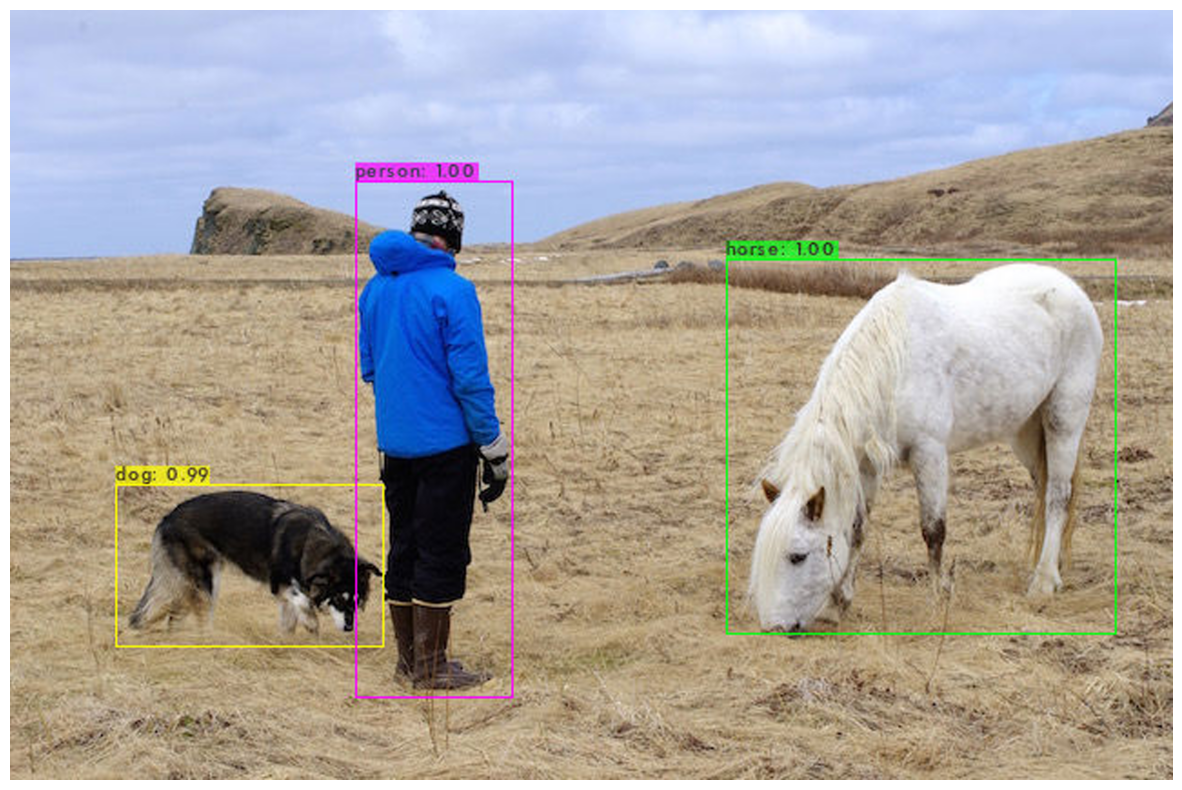

In [12]:
# show image using our helper function
imShow('predictions.jpg')

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

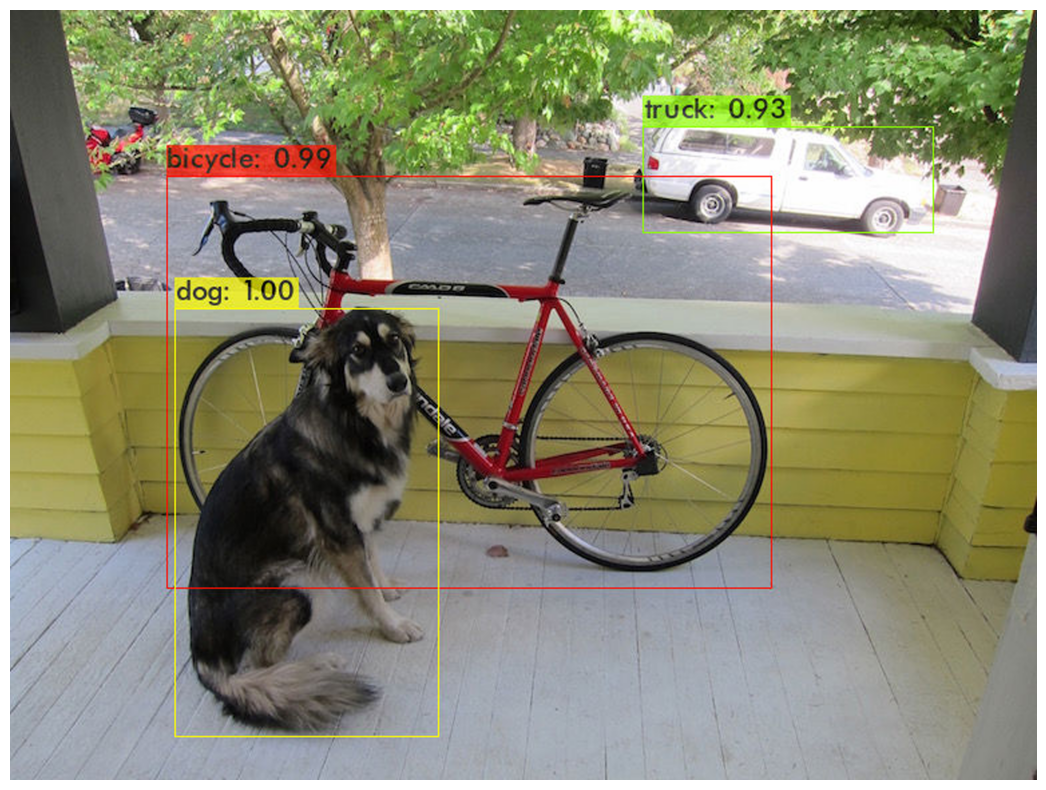

In [13]:
# look we can run another detection
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg
imShow('predictions.jpg')

In [14]:
# this stops 'Runtime/Run all' at this cell by causing an error
assert False

AssertionError: ignored

Uploading Local Files to Use

In [15]:
# upload an image to root directory (I uploaded an image called street.jpg, you can upload anything)
%cd ..
upload() # example: street.jpg

/content


Saving street.jpg to street.jpg
saved file street.jpg


/content/darknet
 CUDA-version: 11080 (12000), cuDNN: 8.7.0, GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sho

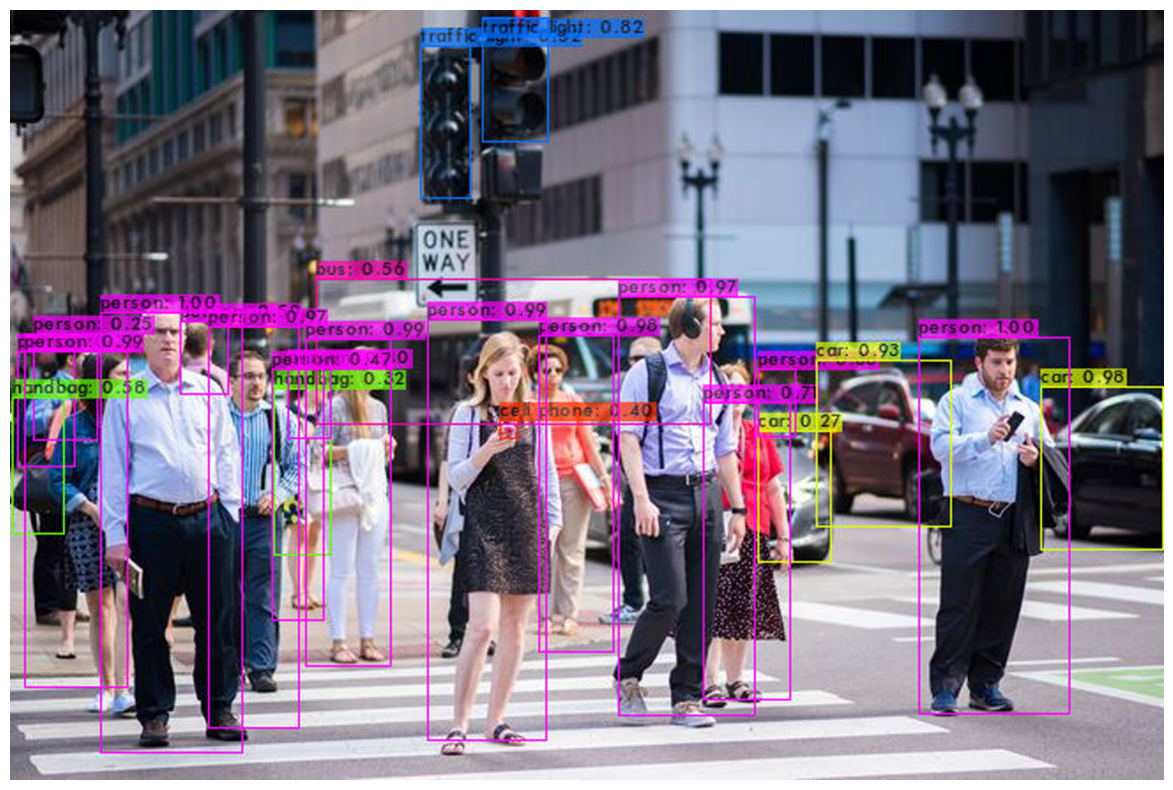

In [16]:
# make sure you are in the darknet folder to run the detections command!
%cd darknet
!./darknet detect cfg/yolov3.cfg yolov3.weights ../street.jpg
imShow('predictions.jpg')

Uploading Google Drive Files to Use

In [17]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [18]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'ABALIA PERFORMANCE'
'Abalia WIZZIE'
'asistenciasEmpleados (1).xls'
'Colab Notebooks'
'CONTRASEÑAS - fecha 14 11 2021 (1).gdoc'
'CONTRASEÑAS - fecha 14 11 2021.gdoc'
'Copiar de Ontología para ingesta incremental (Creación de ontologías históricas) (correo de nieves).gdoc'
'Dedicaciones 2021 Dic: Solicitud reparto de horas.gsheet'
'Diagrama de Gantt.gsheet'
'Documento sin título (1).gdoc'
'Documento sin título (2).gdoc'
'Documento sin título.gdoc'
'DUDAS Y PREGUNTAS.gdoc'
'Hoja de cálculo sin título.gsheet'
 images
'INCIDENCIAS EN ONESITE PLATFORM.gdoc'
'INDRA PERFORMANCE'
'JUSTIFICANTES AUSENCIAS'
'MATERNIDAD DOCUMENTACIÓN'
'MPDT020_20220713 (1).csv'
 MPDT020_20220713.csv
 MPDT020_20220713.gsheet
 MPDT020_20220713_modif.csv
'MPDT055_20220706 (1).csv'
'MPDT055_20220706 (1).gsheet'
'MPDT055_20220706 (2).gsheet'
 MPDT055_20220706.csv
 MPDT055_20220706.gsheet
 MPDT055_20220714_coma.csv
 MPDT055_20220714.csv
'My Drive'
'tarea a realizar.gsheet'
'Trabajo Indra'
 YOLO


/content/darknet
 CUDA-version: 11080 (12000), cuDNN: 8.7.0, GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sho

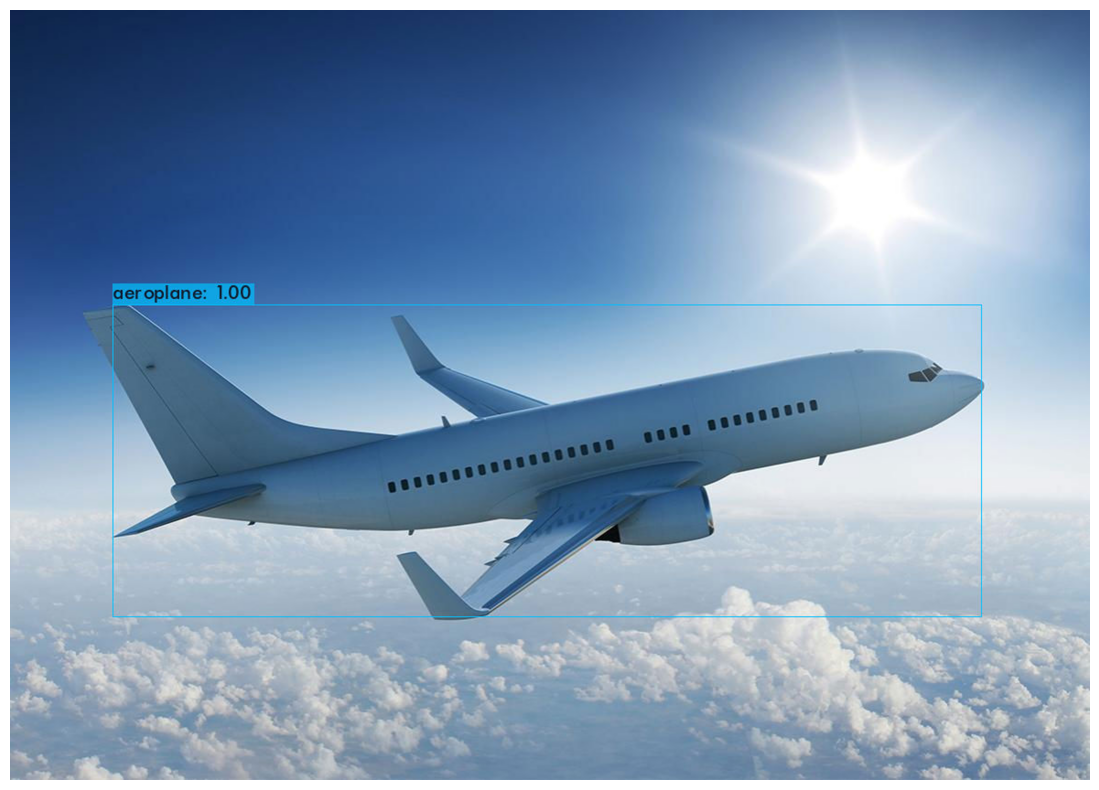

In [19]:
# run darknet command with google drive image (my image path is /images/plane.jpg)
%cd darknet
!./darknet detect cfg/yolov3.cfg yolov3.weights /mydrive/images/plane.jpg
imShow('predictions.jpg')

Download Files to Local Machine or Google Drive from Cloud VM

In [21]:
# LOCAL MACHINE DOWNLOAD
download('predictions.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# GOOGLE DRIVE DOWNLOAD
!cp predictions.jpg /mydrive/images/detection1.jpg

---------------------------- INIT test video (not working yet) -------------------------------------

In [ ]:
!pwd # most be in here /content/darknet if not do %cd darknet

In [ ]:
!apt install ffmpeg libopencv-dev libgtk-3-dev python-numpy python3-numpy libdc1394-22 libdc1394-22-dev libjpeg-dev libtiff5-dev libavcodec-dev libavformat-dev libswscale-dev libxine2-dev libgstreamer1.0-dev libgstreamer-plugins-base1.0-dev libv4l-dev libtbb-dev qtbase5-dev libfaac-dev libmp3lame-dev libopencore-amrnb-dev libopencore-amrwb-dev libtheora-dev libvorbis-dev libxvidcore-dev x264 v4l-utils unzip

In [ ]:
!./darknet detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights -dont_show test.mp4 -i 0 -out_filename output1.avi -thresh 0.7

---------------------------- FIN test video (not working yet) -------------------------------------

Training a Custom YOLOv3 Object Detector in the Cloud!

In [35]:
# this is where my zip is stored (I created a yolov3 folder where I will get my required files from)
!ls /mydrive/YOLO

backup					 obj.names	  yolov3_custom2.cfg
generate_train.py			 obj.zip	  yolov3_custom3.cfg
get_data_from_Googles_Open_Images.ipynb  Untitled0.ipynb  yolov3_custom.cfg
obj.data				 Untitled1.ipynb  yolov3.ipynb


In [36]:
# copy the .zip file into the root directory of cloud VM
!cp /mydrive/YOLO/obj.zip ../

In [37]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../obj.zip -d data/

Archive:  ../obj.zip
   creating: data/obj/
  inflating: data/obj/000396ae942e8778.jpg  
  inflating: data/obj/000396ae942e8778.txt  
  inflating: data/obj/008230603abe6ff1.jpg  
  inflating: data/obj/008230603abe6ff1.txt  
  inflating: data/obj/0084d707a9cca12b.jpg  
  inflating: data/obj/0084d707a9cca12b.txt  
  inflating: data/obj/00f2511c5ec4ac57.jpg  
  inflating: data/obj/00f2511c5ec4ac57.txt  
  inflating: data/obj/01aa20070911c003.jpg  
  inflating: data/obj/01aa20070911c003.txt  
  inflating: data/obj/021bd971230da164.jpg  
  inflating: data/obj/021bd971230da164.txt  
  inflating: data/obj/022887c193d94917.jpg  
  inflating: data/obj/022887c193d94917.txt  
  inflating: data/obj/024ee939e551563b.jpg  
  inflating: data/obj/024ee939e551563b.txt  
  inflating: data/obj/026c1285c93c2a67.jpg  
  inflating: data/obj/026c1285c93c2a67.txt  
  inflating: data/obj/02f6f792b9264e3a.jpg  
  inflating: data/obj/02f6f792b9264e3a.txt  
  inflating: data/obj/0479f21c74968ee5.jpg  
  inflating

Configuring Files for Training

In [25]:
# download cfg to google drive and change its name
!cp cfg/yolov3.cfg /mydrive/YOLO/yolov3_custom3.cfg

Now you need to edit the .cfg to fit your needs based on your object detector. Open it up in a code or text editor to do so.

I recommend having batch = 64 and subdivisions = 16 for ultimate results. If you run into any issues then up subdivisions to 32.

Note: I set my max_batches = 10000, steps = 8000, 9000, I changed the classes = 5 in the three YOLO layers and filters = 30 in the three convolutional layers before the YOLO layers.

Cfg File

In [26]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /mydrive/YOLO/yolov3_custom.cfg ./cfg

# upload the custom .cfg back to cloud VM from local machine (uncomment to use)
#%cd cfg
#upload()
#%cd .. 

obj.names and obj.data

Create a new file within a code or text editor called obj.names and you will make this file exactly the same as your classes.txt in the dataset generation step.

Create a obj.data file and fill it in like this (change your number of classes accordingly, as well as your backup location

In [28]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/YOLO/obj.names ./data
!cp /mydrive/YOLO/obj.data  ./data

# upload the obj.names and obj.data files to cloud VM from local machine (uncomment to use)
#%cd data
#upload()
#%cd .. 

Generating train.txt

In [29]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /mydrive/YOLO/generate_train.py ./

# upload the generate_train.py script to cloud VM from local machine (uncomment to use)
#upload()

In [38]:
# Now run the python script to do all the work for us.
!python generate_train.py

In [39]:
# verify train.txt can be seen in our darknet/data folder
!ls data/

9k.tree      horses.jpg		       openimages.names
coco9k.map   imagenet.labels.list      person.jpg
coco.names   imagenet.shortnames.list  scream.jpg
dog.jpg      labels		       Table_Chair_Laptop_Person
eagle.jpg    obj		       train.txt
giraffe.jpg  obj.data		       voc.names
goal.txt     obj.names


Download pre-trained weights for the convolutional layers.

In [40]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

URL transformed to HTTPS due to an HSTS policy
--2023-05-29 19:51:42--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  57.1MB/s    in 2.7s    

2023-05-29 19:51:45 (57.1 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



Train the Custom Object Detector!

In [ ]:
 # train custom detector
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

Se han truncado las últimas 5000 líneas del flujo de salida.
 total_bbox = 350141, rewritten_bbox = 0.655736 % 
]2;1470/8000: loss=1.2 hours left=9.2
 1470: 1.245353, 1.333958 avg loss, 0.001000 rate, 3.213811 seconds, 94080 images, 9.247879 hours left
Resizing, random_coef = 1.40 

 384 x 384 
 try to allocate additional workspace_size = 142.61 MB 
 CUDA allocate done! 
Loaded: 0.000070 seconds
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.665452), count: 5, class_loss = 0.972815, iou_loss = 0.599100, total_loss = 1.571916 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.692685), count: 6, class_loss = 1.654322, iou_loss = 0.517712, total_loss = 2.172034 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.376358), count: 1, class_loss = 0.422567, iou_loss = 0.357179, total_loss = 0.779746 
 total_bbox = 350153, rewritten_bbox = 0.655713 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 